# Diagnostics of simulation results

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib.colors import LogNorm
import Utilitis_HybridCode as utils


# ... import simulation data
data = np.loadtxt('Results/01_NoDipoleField/simulation_data_T=200_L=2pi.txt')
# ...

In [3]:
# ... get simulation parameters
pa = data[0]

eps0  = pa[0]
mu0   = pa[1]
c     = pa[2]
qe    = pa[3]
me    = pa[4]
B0z   = pa[5]
wce   = pa[6]
wpe   = pa[7]
nuh   = pa[8]
nh    = pa[9]
wpar  = pa[10]
wperp = pa[11]
k     = pa[12]
ini   = np.int(pa[13])
amp   = pa[14]
eps   = pa[15]
Lz    = pa[16]
Nz    = np.int(pa[17])
T     = pa[18]
dt    = pa[19]
p     = np.int(pa[20])
Lv    = pa[21]
Nv    = np.int(pa[22])
Np    = np.int(pa[23])
xi    = pa[24]
Ld    = pa[25]

bcs_p = pa[26]
bcs_f = pa[27]
bcs_d = pa[28]
bcs_g = pa[29]
saving_step = pa[30]
# ...

In [12]:
saving_step = 5

In [29]:
# ... additional parameters 
if bcs_f == 1:
    Nb = Nz
elif bcs_f == 2:
    Nb = Nz + p - 2
s = 6
# ...



# ... get simulation data
if bcs_f == 1:

    uj = data[1:, 0:s*Nb]
    yhj = data[1:, s*Nb:8*Nb]
    
    Nt_data = len(uj[:, 0]) - 1
    dt_data = dt*saving_step
    tn_data = np.linspace(0, Nt_data*dt_data, Nt_data + 1)

    ejx  = uj[:, 0::6]
    ejy  = uj[:, 1::6]
    bjx  = uj[:, 2::6]
    bjy  = uj[:, 3::6]
    ycjx = uj[:, 4::6]
    ycjy = uj[:, 5::6]
    yhjx = yhj[:, 0::2]
    yhjy = yhj[:, 1::2]
    
    en_e  = data[1:, -5]
    en_b  = data[1:, -4]
    en_jc = data[1:, -3]
    en_jh = data[1:, -2]

elif bcs_f == 2:
    

    uj = data[1:, 0:s*Nb]
    yhj = data[1:, s*Nb:8*Nb]
    
    Nt_data = len(uj[:, 0]) - 1
    dt_data = dt*saving_step
    tn_data = np.linspace(0, Nt_data*dt_data, Nt_data + 1)

    ejx = np.c_[np.zeros(Nt_data + 1), uj[:, 0::6], np.zeros(Nt_data + 1)]
    ejy = np.c_[np.zeros(Nt_data + 1), uj[:, 1::6], np.zeros(Nt_data + 1)]
    bjx = np.c_[np.zeros(Nt_data + 1), uj[:, 2::6], np.zeros(Nt_data + 1)]
    bjy = np.c_[np.zeros(Nt_data + 1), uj[:, 3::6], np.zeros(Nt_data + 1)]
    
    ycjx = np.c_[np.zeros(Nt_data + 1), uj[:, 4::6], np.zeros(Nt_data + 1)]
    ycjy = np.c_[np.zeros(Nt_data + 1), uj[:, 5::6], np.zeros(Nt_data + 1)]
    yhjx = yhj[:, 0::2]
    yhjy = yhj[:, 1::2]
# ...


# ... define fields
def damp(z):
    return 0*z

def B0(z):
    return 0*z
# ...


# ... create B-spline basis and compute mass matrix
basis, N, quad_points, weights = utils.createBasis(Lz, Nz, p, bcs_f)
M = utils.matrixAssembly(basis, weights, quad_points, B0, bcs_f)[0]
# ...



# ... solve the dispersion relation for a fixed k to get ocillation frequency and growth rate 
omega = utils.solveDispersionHybrid(k, +1 , c, wce, wpe, wpar, wperp, nuh, 0.5 + 0j, 1e-6, 100)[0]
omega_r = np.real(omega)
gamma = np.imag(omega)
# ...

In [14]:
dt_data

0.25

"\nplt.subplot(223)\nplt.contourf(Time,Omega,Sxx,100,cmap = 'jet')\n#plt.contourf(Time,Omega,Sxx,norm = LogNorm(),levels = lvls, cmap = 'jet')\n\nplt.plot(np.linspace(t[0],t[-1],100),np.ones(100)*omega_r*2,'k--')\nplt.xlabel('t |wce|')\nplt.xlabel('w / |wce|')\nplt.ylim((0,2))\nplt.colorbar()\nplt.title('time-frequency spectrogram')\n"

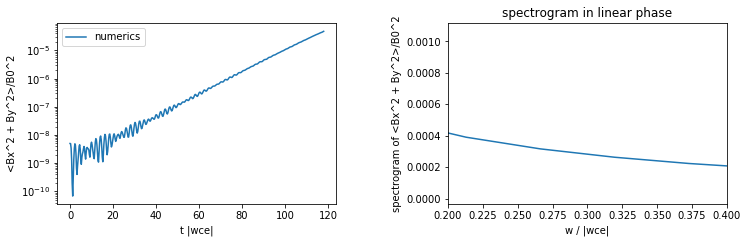

In [30]:
# ... compute averaged quadratic magnetic field (x and x + y)
mean_Bx2 = np.zeros(Nt_data + 1)
mean_B2  = np.zeros(Nt_data + 1)

for j in range(0, Nt_data + 1):
    mean_Bx2[j] = 1/Lz*(np.dot(bjx[j], np.dot(M, bjx[j])))
    mean_B2[j]  = 1/Lz*(np.dot(bjx[j], np.dot(M, bjx[j])) + np.dot(bjy[j], np.dot(M, bjy[j])))
# ...

                       
                       
# ... compute fft for frequency analysis in linear phase 
Ntend = Nt_data
spec = np.fft.fft(mean_Bx2[0:Ntend + 1])
spec = np.fft.fftshift(spec)
w = np.linspace(0, Ntend, Ntend + 1) - Ntend/2
w = 2*np.pi*w/(Ntend*dt_data)
# ...



                       
# ... plot results
f1 = plt.figure()
f1.set_figheight(8)
f1.set_figwidth(12)
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)

plt.subplot(221)
plt.semilogy(tn_data,mean_B2,label = 'numerics')
t2 = np.linspace(0,T,100)
#plt.semilogy(t2,1.2e-9*np.exp(t2*gamma*2),label = 'expected growth rate')
plt.xlabel('t |wce|')
plt.ylabel('<Bx^2 + By^2>/B0^2')
#plt.xlim((0,80))
#plt.ylim((5e-6,5e-3))
plt.legend()

plt.subplot(222)
plt.plot(w,np.abs(spec))
plt.xlim((0.2,0.4))
plt.xlabel('w / |wce|')
plt.ylabel('spectrogram of <Bx^2 + By^2>/B0^2')
#plt.plot(np.ones(20)*2*omega_r,np.linspace(0,4e-6,20),label = 'expected real frequency')
#plt.legend()
plt.title('spectrogram in linear phase')

'''
plt.subplot(223)
plt.contourf(Time,Omega,Sxx,100,cmap = 'jet')
#plt.contourf(Time,Omega,Sxx,norm = LogNorm(),levels = lvls, cmap = 'jet')

plt.plot(np.linspace(t[0],t[-1],100),np.ones(100)*omega_r*2,'k--')
plt.xlabel('t |wce|')
plt.xlabel('w / |wce|')
plt.ylim((0,2))
plt.colorbar()
plt.title('time-frequency spectrogram')
'''
# ...

In [22]:
Bx = np.zeros(Nt_data + 1)

for i in range(0, Nt_data + 1):
    if i%500 == 0:
        print(i)
    Bx[i] = utils.evaluation(bjx[i], basis, zj, np.array([Lz/2 - 25]), bcs_f)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


In [30]:
t

array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
        900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700.,
       1800., 1900., 2000., 2100., 2200., 2300., 2400., 2500., 2600.,
       2700., 2800., 2900., 3000., 3100., 3200., 3300., 3400., 3500.,
       3600., 3700., 3800., 3900., 4000., 4100., 4200., 4300., 4400.,
       4500., 4600., 4700., 4800., 4900., 5000., 5100., 5200., 5300.,
       5400., 5500., 5600.])

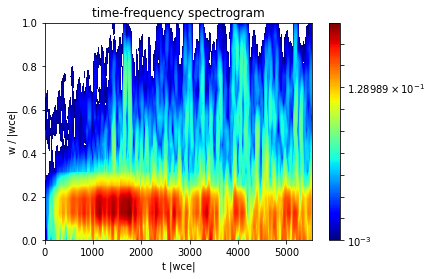

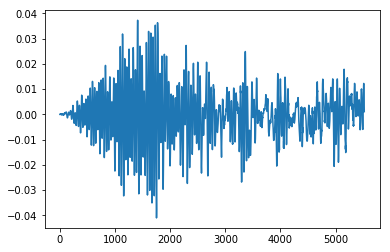

In [34]:
# ... compute time-frequency spectrum
f, t, Sxx = np.abs(signal.stft(Bx, 1/dt_data, nperseg = 100, noverlap = 80, nfft = None))
om = 2*np.pi*f
lvls = np.logspace(-3,0,200)
Time, Omega = np.meshgrid(t, om)
# .


#plt.contourf(Time, Omega, Sxx/Sxx.max(), 500, cmap = 'jet')
plt.contourf(Time,Omega,Sxx/Sxx.max(),norm = LogNorm(),levels = lvls, cmap = 'jet')
#plt.contourf(Time,Omega,Sxx/Sxx.max(),norm = LogNorm(), cmap = 'jet')

#plt.plot(np.linspace(t[0],t[-1],100),np.ones(100)*omega_r*2,'k--')
plt.xlabel('t |wce|')
plt.ylabel('w / |wce|')
plt.ylim((0,1))
#plt.xlim((1500,2500))
plt.colorbar()
plt.title('time-frequency spectrogram')

plt.figure()
#plt.plot(tn[10000:18000],Bx[10000:18000])
plt.plot(tn_data, Bx)

(0, 1)

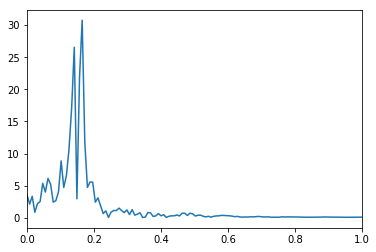

In [100]:
Nstart = 10000
Nend = 18000
Delta = Nend - Nstart
spec = np.fft.fft(Bx[Nstart:Nend+1])
spec = np.fft.fftshift(spec)
w = np.linspace(0,Delta,Delta+1) - Delta/2
w = 2*np.pi*w/(Delta*dt)
plt.plot(w,np.abs(spec))
plt.xlim((0,1))

In [29]:
# ... compute 2D fft to investigate dispersion relation
w = np.linspace(0, Nt_data, Nt_data + 1) - Nt_data/2
w = 2*np.pi/T*w

ks = np.linspace(0, Nz, Nz + 1) - Nz/2
ks = 2*np.pi/Lz*ks

Bx = np.zeros((Nt_data + 1, Nz + 1))

for i in range(0, Nt_data + 1):
    if i%500 == 0:
        print('time steps finished: ' + str(i))
    Bx[i] = utils.evaluation(bjx[i], basis, zj, zj, bcs_f)

time steps finished: 0
time steps finished: 500
time steps finished: 1000
time steps finished: 1500
time steps finished: 2000
time steps finished: 2500
time steps finished: 3000


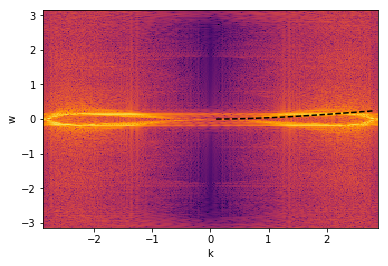

In [36]:
Bxkw = np.fft.fft2(Bx)
K, W = np.meshgrid(ks, w)
Bkw = np.fft.fftshift(Bxkw)
Bkw_plot = np.abs(Bkw)/np.abs(Bkw).max()
plt.pcolor(K, W, Bkw_plot, cmap = 'inferno', norm = LogNorm(vmin = Bkw_plot.min(), vmax = Bkw_plot.max()))
#plt.xlim((0, 6))
#plt.ylim((0, 5))
plt.xlabel('k')
plt.ylabel('w')

# ... Newton method for cold plasma dispersion relation for fixed k
k1 = np.linspace(0.1, 2.8, 40)

w1_1 = np.zeros(40)
w1_2 = np.zeros(40)
w1_3 = np.zeros(40)

w1_1[0] = 0.0001 
w1_2[0] = 1.5001 
w1_3[0] = 2.5001


for i in range(0, 40):
    
    if i == 0:
        w1_1[i] = utils.solveDispersionCold(k1[i],+1,c,wce,wpe,w1_1[i],1e-6,100)[0]
        w1_2[i] = utils.solveDispersionCold(k1[i],-1,c,wce,wpe,w1_2[i],1e-6,100)[0]
        w1_3[i] = utils.solveDispersionCold(k1[i],+1,c,wce,wpe,w1_3[i],1e-6,100)[0]
    
    else:
        w1_1[i] = utils.solveDispersionCold(k1[i],+1,c,wce,wpe,w1_1[i-1],1e-6,100)[0]
        w1_2[i] = utils.solveDispersionCold(k1[i],-1,c,wce,wpe,w1_2[i-1],1e-6,100)[0]
        w1_3[i] = utils.solveDispersionCold(k1[i],+1,c,wce,wpe,w1_3[i-1],1e-6,100)[0]
    
# ...

plt.plot(k1,w1_1,'k--')
#plt.plot(k1,w1_2,'k--')
#plt.plot(k1,w1_3,'k--')